# Advent of Code 2024 Solutions

First, let's import all the packages we'll use:

In [1]:
import numpy as np
import re
import networkx as nx
import itertools
import math
import copy

# [Day 1 Historian Hysteria](https://adventofcode.com/2024/day/1)

In [7]:
file = open('input1.txt', 'r')
input_text = file.read()
file.close()

## Part 1

Starting off pretty easy - let's just convert our lists to vectors, sort by size, and then take the difference.

In [8]:
def create_lists(input_text):
    lines = input_text.strip().splitlines()
    left_list = []
    right_list = []
    for line in lines:
        left, right = line.split()
        left_list.append(int(left))
        right_list.append(int(right))
    return left_list, right_list

In [11]:
left_list, right_list = create_lists(input_text)
left_list = np.sort(left_list)
right_list = np.sort(right_list)
np.sum(np.absolute(right_list-left_list))

2367773

## Part 2

This one's also pretty chill. We can just loop through each value in left list and count how many times it appears in the right list.

In [13]:
score = 0
for num in left_list:
    score += num * np.count_nonzero(right_list == num)
score

21271939

# [Day 2: Red-Nosed Reports](https://adventofcode.com/2024/day/2)

In [1]:
file = open('input2.txt', 'r')
input_text = file.read()
file.close()

## Part 1

In [2]:
def read_reports(input_text):
    lines = input_text.strip().splitlines()
    
    reports = []
    for line in lines:
        reports.append([int(level) for level in line.split()])
    return reports

In [3]:
reports = read_reports(input_text)

A report is safe if its **strictly monotonic**, and each consecutive difference is **between $1$ and $3$ in absolute value**. We'll create a function to test for this and then run this function on every report in our list.

In [4]:
def is_report_safe(report):
    differences = []
    for i in range(len(report) - 1):
        differences.append(report[i+1]-report[i])
    strictly_monotonic = all(num < 0 for num in differences) or all(num > 0 for num in differences)
    gradual = all(1 <= num and 3 >= num for num in [abs(difference) for difference in differences])
    return strictly_monotonic and gradual

In [5]:
number_safe = 0
for report in reports:
    if is_report_safe(report):
        number_safe += 1
number_safe

502

## Part 2 

For each report, we can see if it only has one bad level by removing each level and seeing if the remaining levels constitute a safe report.

In [7]:
number_safe = 0
for report in reports:
    for i in range(len(report)):
        if is_report_safe([level for j, level in enumerate(report) if j != i]):
            number_safe += 1
            break
number_safe

544

# [Day 3: Mull It Over](https://adventofcode.com/2024/day/3)

In [2]:
file = open('input3.txt', 'r')
input_text = file.read()
file.close()

## Part 1

We can use a simple **regular expression** to detect all substrings of the form `mul(X,Y)` where `X` and `Y` are 1-3 digit numbers

In [3]:
mem = input_text

In [4]:
regex = r"mul\((-?\d+),(-?\d+)\)"
def extract_multiplications(mem):
    total = 0
    matches = re.findall(regex, mem)
    for match in matches:
        total += int(match[0])*int(match[1])
    return total

In [6]:
# mult_regex = r"mul\((-?\d+),(-?\d+)\)"
extract_multiplications(mem)

167090022

## Part 2

We just have to preprocess our string a bit for part 2. We can split our string into blocks separated by `don't()`'s. Since the multiplication instructions are **enabled at the beginning**, we can count all the multiplications in the first block. In the other blocks, we only want to count multiplications **after the first `do()`**, since the start of each block follows a `don't()`.

In [7]:
blocks = mem.split("don't()")
total = 0
for block in blocks[1:]:
    do = str(block.split("do()", 1)[1:])
    total += extract_multiplications(do)
total += extract_multiplications(blocks[0])
total

89823704

# [Day 4: Ceres Search](https://adventofcode.com/2024/day/4)

In [2]:
file = open('input4.txt', 'r')
input_text = file.read()
file.close()

## Part 1

In [10]:
def read_word_search(input_text):
    lines = input_text.strip().splitlines()

    # We'll pad our array so when we use numpy vector as indices, we don't have to worry about going out of bounds.
    word_search = [['.']*(len(lines[0])+2)] 
    
    for line in lines:
        row = ['.']
        for col_index, char in enumerate(line):
            row.append(char) 
        row.append('.')
        word_search.append(row)
    word_search.append(['.']*(len(lines[0])+2))
    return word_search

In [4]:
word_search = read_word_search(input_text)

For each character in our word search, we'll iterate in each direction and check if those characters spell "XMAS."

In [5]:
def detect_xmas(i, j, direction, word_search):
    current = np.array([i,j])
    for i in range(4):
        ith_letter = current + i * direction
        if word_search[ith_letter[0]][ith_letter[1]] != "XMAS"[i]:
            return 0
    return 1

In [6]:
directions = [np.array(direction) for direction in [(-1,0),(0,1),(1,0),(0,-1),(1,1),(1,-1),(-1,-1),(-1,1)]]    
total = 0
for i, row in enumerate(word_search):
    for j, entry in enumerate(row):
        if entry == '.':
            continue
        for direction in directions:
            total += detect_xmas(i, j, direction, word_search)
total

2406

## Part 2

Not much extra stuff to do here. We just have to get a little fancier to get the neighboring letters. For any given `A`, we just have to check the cells neighboring it diagonally. Below, we flatten out our diagonals from the bottom left to the top right. So if we have a diagonal crossing that looks like,

$\begin{bmatrix} x_1 & . & x_2 \\ . & x_3 & . \\ x_4 & . & x_5 \end{bmatrix}$, 

we map this to the string $x_4x_5x_3x_1x_2$. We then check to see if this matches one of the four possible`X-MAS`'s.

In [7]:
valid_x_mas = {"MSAMS","MMASS","SMASM","SSAMM"}
def detect_x_mas(i, j, word_search):
    cross = ""
    parity_checker = (i+j) % 2
    for k in range(i-1, i+2):
        for l in range(j-1, j+2):
            if (k + l) % 2 == parity_checker: 
                cross += word_search[k][l]
    return 1 if cross in valid_x_mas else 0

In [8]:
x_mas_total = 0
for i, row in enumerate(word_search):
    for j, entry in enumerate(row):
        if entry == '.':
            continue
        x_mas_total += detect_x_mas(i, j, word_search)
x_mas_total

1807

# [Day 5: Print Queue](https://adventofcode.com/2024/day/5)

In [2]:
file = open('input5.txt', 'r')
input_text = file.read()
file.close()

## Part 1

In [3]:
def get_rules_and_updates(input_text):
    rules, updates = input_text.strip().split("\n\n")
    rules = rules.split('\n')
    updates = updates.split('\n')
    return rules, updates

In [5]:
rules, updates = get_rules_and_updates(input_text)
rules = set(tuple(rule.split('|')) for rule in rules)

Since the rules give us a way to order updates of pages, we can just use **quick sort** with `|` in place of `<`. Once we get a sorted list of pages according to the rules, we can check if the update matches the sorted list of pages.

*Digression: Initially I assumed that the rules would form a total ordering of the pages since this was the case in the small example that the problem gave. So my first approach was just to attempt to sort all of the pages at the beginning, which is why I thought to use quick sort. After spending some time being very confused as to why my code wasn't working, I **finally** checked the input for the first time. It was a good lesson to check my input before writing the solution for later days.*

In [6]:
def quicksort(lst):
    if len(lst) == 0:
        return []
    pivot = lst[0]
    left = []
    right = []
    for elt in lst[1:]:
        if (elt, pivot) in rules:
            left.append(elt)
        else:
            right.append(elt)
    return quicksort(left) + [pivot] + quicksort(right)

In [7]:
total = 0 
for update in updates:
    update_pages = update.split(',')
    sorted_pages = quicksort(update_pages)
    mapped_update = [sorted_pages.index(page) for page in update_pages]
    monotonic = all([mapped_update[i] < mapped_update[i+1] for i in range(len(mapped_update) - 1)])
    if monotonic:
        total += int(update_pages[int((len(mapped_update)-1)/2)])
total

5588

## Part 2

This should be pretty easy since we already sorted updates into the correct order in Part 1.

In [8]:
total = 0 
for update in updates:
    update_pages = update.split(',')
    sorted_pages = quicksort(update_pages)
    mapped_update = [sorted_pages.index(page) for page in update_pages]
    monotonic = all([mapped_update[i] < mapped_update[i+1] for i in range(len(mapped_update) - 1)])
    if not monotonic:
        total += int(sorted_pages[int((len(mapped_update)-1)/2)])
total

5331

# [Day 6: Guard Gallivant](https://adventofcode.com/2024/day/6)

In [2]:
file = open('input6.txt', 'r')
input_text = file.read()
file.close()

## Part 1

In [3]:
def read_map(input_text):
    lines = input_text.strip().splitlines()
    # We'll pad the borders of our map
    matrix = [['@' for i in range(len(lines[0])+2)]]

    for row_index, line in enumerate(lines):
        row = ['@']
        for col_index, char in enumerate(line):
            if char == '#':
                row.append("#")
            else:
                row.append('.')
            if char == '^':
                start_position = (row_index+1, col_index+1)
        row.append('@')
        matrix.append(row)
    matrix.append(['@' for i in range(len(lines[0])+2)])
    
    return matrix, np.array(start_position)

In [4]:
guard_map, start_position = read_map(input_text)

We will run a loop to make the guard step forward if she is able to and turn right 90 degrees if she's facing an obstruction. We continue until she hits the edge of the map.

In [5]:
directions = [np.array(direction) for direction in [(-1,0),(0,1),(1,0),(0,-1)]]
orientation = 0
position = np.copy(start_position)
squares = set()
while True:
    squares.add(tuple(position))
    next_position = position + directions[orientation]
    if guard_map[next_position[0]][next_position[1]] == "@":
        break
    elif guard_map[next_position[0]][next_position[1]] == "#":
        orientation = (orientation+1) % 4
    else:
        position = next_position

In [6]:
len(squares)

4656

## Part 2

Since the guard follows the same patrol protocol every time, she becomes **stuck in a loop if and only if she visits a position she has already visited in the same orientation as before**. Thus, to detect whether adding an obstruction to a given position will cause the guard to get stuck, we can do the same thing as in Part 1 while also storing the orientation of the guard at each step. Then if the guard visits a spot she's been before in the same orientation as before, she is stuck in a loop. Otherwise, she exits the mapped area without entering a loop. Repeating this process for every position in the mapped area will give us all possible positions where an added obstruction would cause a loop.

To reduce our search space, we observe that any obstruction placed outside of the guard's original path won't cause her to get stuck in a loop since she will never run into this obstruction. This allows us to **only search positions on the guard's original path**. Moreover, the path that the guard traces out when we add the obstruction **will only differ once she reaches the position of the added obstruction** for the first time. So if we compute the guards position and orientation on her original path, we won't have to recompute her entire path every time we add an obstruction. 

In [7]:
# Get guards positions and orientations before adding an obstruction
orientation = 0
position = np.copy(start_position)
squares_oriented = []
squares_index = {}
idx = 0
while True:
    # Record the first time we reach a position
    if tuple(position) not in squares_index:
        squares_index[tuple(position)] = idx
    idx += 1
    squares_oriented.append((tuple(position), orientation))
    next_position = position + directions[orientation]
    if guard_map[next_position[0]][next_position[1]] == "@":
        break
    elif guard_map[next_position[0]][next_position[1]] == "#":
        orientation = (orientation+1) % 4
    else:
        position = next_position

Now for each visited square, we add an obstruction and run our above algorithm to detect a loop. We will modify our original `guard_map` rather than making a copy every iteration. To make sure we return the `guard_map` to its original state after each test, we will use a **decorator** to make the appropriate changes to the `guard_map` before and after calling our loop detecting function.

In [10]:
def add_obstruction(fun):
    def wrapper(obstruction, guard_map):
        i,j = obstruction
        guard_map[i][j] = '#'
        result = fun(obstruction, guard_map)
        guard_map[i][j] = '.'
        return result
    return wrapper

@add_obstruction
def creates_loop(obstruction, guard_map):
    first = squares_index[obstruction] - 1 # Get the first time we visit the position where we want to place an obstruction
    position, orientation = squares_oriented[first]
    squares_visited = set(squares_oriented[:first]) # Get the guard's path up to this point
    while True:
        position_orientation = (tuple(position), orientation)
        if tuple(position_orientation) in squares_visited:
            return True
        squares_visited.add(position_orientation)
        next_position = position + directions[orientation]
        if guard_map[next_position[0]][next_position[1]] == "@":
            return False
        if guard_map[next_position[0]][next_position[1]] == "#":
            orientation = (orientation+1) % 4
        else:
            position = next_position

In [11]:
total = 0
for entry in squares:
    if entry == tuple(start_position):
        continue
    if creates_loop(entry, guard_map):
        total += 1
total

1575

# [Day 7: Bridge Repair](https://adventofcode.com/2024/day/7)

In [1]:
file = open('input7.txt', 'r')
input_text = file.read()
file.close()

## Part 1

In [7]:
def read_equations(input_text):
    equations = []
    lines = input_text.strip().splitlines()    
    for equation in lines:
        data = equation.split(' ')
        test_value = int(data[0][:-1])
        nums = tuple(int(value) for value in data[1:])
        equations.append({
            'test_value': test_value,
            'nums': nums,
        })
    return equations

In [8]:
equations = read_equations(input_text)

We'll use recursion here. For a given sequence of numbers $x_1 \ x_2 \ \ldots \ x_{n-1} \ x_n$ in an equation, we compute all the possible results we could get from different combinations of operations for the sequence $x_1 \ x_2 \ \ldots \ x_{n-1}$. Then for each number in this set, we add or multiply $x_n$ to get all the possible values we could get by inserting different combinations of operations into our entire sequence. I'm not sure whether memoizing is necessary here, but why not?

In [9]:
memoization_table = {}
def get_combinations(nums):
    if len(nums) == 1:
        return set(nums)
    last = nums[-1]
    subtuple = nums[:-1]
    if subtuple in memoization_table.keys():
        rest = memoization_table[subtuple]
    else:
        rest = get_combinations(subtuple)
        memoization_table[subtuple] = rest
    return set(last + combination for combination in rest) | set(last * combination for combination in rest)

In [10]:
total = 0
for equation in equations:
    test_value = equation['test_value']
    nums = equation['nums']
    if test_value in get_combinations(nums):
        total += test_value
total

303766880536

## Part 2

We'll apply the same recursive method as above but now we throw in the concatenation operator in the inductive step.

In [11]:
memoization_table2 = {}
def get_combinations2(nums):
    if len(nums) == 1:
        return set(nums)
    last = nums[-1]
    subtuple = nums[:-1]
    if subtuple in memoization_table2.keys():
        rest = memoization_table2[subtuple]
    else:
        rest = get_combinations2(subtuple)
        memoization_table[subtuple] = rest
    return set(last + combination for combination in rest) | set(last * combination for combination in rest) | set(int(str(combination) + str(last)) for combination in rest)

In [12]:
total = 0
for equation in equations:
    test_value = equation['test_value']
    nums = equation['nums']
    if test_value in get_combinations2(nums):
        total += test_value
total

337041851384440

# [Day 8: Resonant Collinearity](https://adventofcode.com/2024/day/8)

In [2]:
file = open('input8.txt', 'r')
input_text = file.read()
file.close()

## Part 1

In [3]:
def read_grid(input_text):
    lines = input_text.strip().splitlines()
    grid = []
    for line in lines:
        row = []
        for char in line:
            row.append(char)
        grid.append(row)
    return grid

In [4]:
grid = read_grid(input_text)

First, for each unique character/frequency, we'll get a **list of coordinates** where that character appears.

In [6]:
def get_character_positions(grid):
    character_positions = {}
    for i, row in enumerate(grid):
        for j, value in enumerate(row):
            if value == ".":
                continue
            if value in character_positions.keys():
                character_positions[value].add((i,j))
            else:
                character_positions[value] = {(i,j)}
    return character_positions

In [7]:
character_positions = get_character_positions(grid)

We're given that an antinode only occurs when it's **aligned with two antennas of the same frequency**, and the **distance from one of the antennas is twice as far as the distance from the other antenna**. So for every pair of antennas $a_1, a_2 \in \mathbb{Z}^2$ with the same frequency, the two possible antinodes will be $(a_2 - a_1) + a_2$ and $a_1 - (a_2 - a_1)$. Thus, for any such pair, we just check if these two coordinates are in the bounds of our grid.

In [8]:
def is_valid_coord(coordinates):
    return coordinates[0] >= 0 and coordinates[1] >= 0 and coordinates[0] < len(grid) and coordinates[1] < len(grid[0])

def get_antinodes(antennas):
    antinodes = set()
    antennas_np = [np.array(antenna) for antenna in antennas]
    pairs = itertools.combinations(antennas_np, 2)
    for combo in pairs:
        p1, p2 = combo
        difference = p2 - p1
        antinode1 = p1 - difference
        antinode2 = p2 + difference
        
        if is_valid_coord(antinode1):
            antinodes.add(tuple(antinode1))
        if is_valid_coord(antinode2):
            antinodes.add(tuple(antinode2))
    return antinodes

In [9]:
antinodes = set()
for char in character_positions.keys():
    antinodes = antinodes | get_antinodes(character_positions[char])
len(antinodes)

289

## Part 2

For part 2, antinodes can occur at **any point that is collinear** with two antennas of the same frequency. Thus, for any pair of same-frequency antennas $a_1, a_2$, we can parametrize the line they lie on to enumerate all integer points on this line. We again look at the difference vector $a_2 - a_1$, but to ensure we attain all possible integer values on this line, we need to scale down by the $\gcd$ of its $x$ and $y$ coordinates. As before, we only have to do this for points that fit within the bounds of our grid.

In [13]:
def get_antinodes_2(antennas):
    antinodes = set()
    antennas_np = [np.array(antenna) for antenna in antennas]
    pairs = itertools.combinations(antennas_np, 2)
    for combo in pairs:
        p1, p2 = combo
        difference = p2 - p1
        gcd = math.gcd(int(difference[0]), int(difference[1]))
        difference = ((1/gcd)*difference).astype(int)
        
        current = copy.deepcopy(p1)
        while is_valid_coord(current):
            antinodes.add(tuple(current))
            current += difference

        current = copy.deepcopy(p1)
        while is_valid_coord(current):
            antinodes.add(tuple(current))
            current -= difference

    return antinodes

In [14]:
antinodes = set()
for char in character_positions.keys():
    antinodes = antinodes | get_antinodes_2(character_positions[char])
len(antinodes)

1030

# Day 9

# [Day 10: Hoof It](https://adventofcode.com/2024/day/10)

## Part 1

In [2]:
file = open('input10.txt', 'r')
input_text = file.read()
file.close()

In [3]:
def read_map(input_text):
    lines = input_text.strip().splitlines()

    # Add a buffer to the sides of the map
    topographic_map = [[11 for i in range(len(lines[0])+2)]]
    
    for row_index, line in enumerate(lines):
        row = [11]
        for col_index, char in enumerate(line):
            if char == ".":
                row.append(-1)
            else:
                row.append(int(char))   
        row.append(11)
        topographic_map.append(row)
    topographic_map.append([11 for i in range(len(lines[0])+2)])
    return topographic_map

We can view our topographic map as a directed graph $G = (V,A)$ with vertices $V = \{(i,j) \ | \ 1 \leq i \leq \text{\# of rows}, \ 1 \leq j \leq \text{\# of cols} \}$. A pair $((i,j), (k,l))$ is an arc when $(i,j)$ and $(k,l)$ are vertical or horizontal neighbors and the height at $(i,j)$ is exactly one less than the height at $(k,l)$.

Then to find the **score of a trailhead** with height $0$, we can apply breadth-first search (BFS) to find all reachable vertices in $G$ and count the number of distinct vertices with height $9$ that are reachable.

In [4]:
topographic_map = read_map(input_text)

In [5]:
directions = [np.array(direction) for direction in [(-1,0),(0,1),(1,0),(0,-1)]]

def bfs(start):
    # Initialize every vertex except the start is unreachable
    reachable = [[0 for i in range(len(topographic_map[0]))] for j in range(len(topographic_map))]
    reachable[start[0]][start[1]] = 1 

    # Now explore the neighbors of every reachable vertex whose neighbors we haven't visited before
    queue = [start]
    while len(queue) > 0: 
        current_node = queue[0]
        reachable[current_node[0]][current_node[1]] = 1
        for direction in directions:
            neighbor = current_node + direction
            if topographic_map[neighbor[0]][neighbor[1]] == (topographic_map[current_node[0]][current_node[1]] + 1):
                queue.append(neighbor)
        queue.pop(0)
    return reachable

The above function implements BFS, so now let's get the indices of all the $0$-height and $9$-height values and apply our algorithm to every trailhead.

In [6]:
def get_indices_of_value(value):
    return [(i,j) for i, row in enumerate(topographic_map) for j, elt in enumerate(row) if elt == value]

In [7]:
zeroes = get_indices_of_value(0)
nines = get_indices_of_value(9)

In [8]:
scores = {}
for zero in zeroes:
    scores[zero] = []
    reachable = bfs(np.array(zero))
    for nine in nines:
        if reachable[nine[0]][nine[1]]:
            scores[zero].append(nine)

In [9]:
sum([len(score) for score in scores.values()])

550

## Part 2

To find the number of **distinct paths** between a $0$-height position and a $9$-height position, we can use our standard path-counting algorithm. If `count_paths(u,v)` gives us the number of directed paths between vertices $u,v \in V$, we can look at all the neighbors $w_1, \ldots w_k$ of $v$ such that $(w_i, v) \in A$. Then 

`count_paths(u,v) = count_paths(u,w1) + ... + count_paths(u,wk)`. 

Alright, let's implement this. Again, not sure if memoization is necessary for this size of map, but it won't hurt.

In [10]:
memoization_table = {}
def count_paths(start, end):
    # Base case
    if (topographic_map[end[0]][end[1]] == topographic_map[start[0]][start[1]] + 1) and any(np.array_equal(end, start + direction) for direction in directions):
        return 1

    # Recursive step
    total = 0
    for direction in directions:
        neighbor = end + direction
        if topographic_map[neighbor[0]][neighbor[1]] == topographic_map[end[0]][end[1]] - 1:
            key = tuple(np.concatenate((start, neighbor), axis=None))
            if key in memoization_table.keys():
                neighbor_count = memoization_table[key]
            else:
                neighbor_count = count_paths(start, neighbor)
                memoization_table[key] = neighbor_count
            total += neighbor_count
    return total

Now we just run this function between each trailhead and trailtop.

In [11]:
total = 0
for zero in scores.keys():
    for nine in scores[zero]:
        total += count_paths(zero, nine)

In [12]:
total

1255

# [Day 11: Plutonian Pebbles](https://adventofcode.com/2024/day/11)

## Part 1

In [2]:
file = open('input11.txt', 'r')
input_text = file.read()
file.close()

In [3]:
stones = [int(stone) for stone in input_text.strip().split(' ')]

Since each stone changes **simultaneously** by the **same rules**, we can apply the appropriate to change to each stone individually in order and place all the results in a list. Then we just repeat this 25 times to get our final answer.

In [4]:
def change(stone):
    if stone == 0:
        return [1]
    s = str(stone)
    if len(s) % 2 == 0:
        return [int(s[:int(len(s)/2)]), int(s[int(len(s)/2):])]
    return [stone*2024]

def blink(stones):
    new_stones = []
    for stone in stones:
        new_stones += change(stone)
    return new_stones

In [5]:
stones_temp = [stone for stone in stones]
for i in range(0,25):
    stones_temp = blink(stones_temp)

In [6]:
len(stones_temp)

186203

## Part 2

Since blinking will cause the number of stones to **potentially double**, the number of times we have to run `change` grows **exponentially** in the worst case. So it's probably not the best idea to try and apply the same strategy as before 75 times. Instead, we notice that whenever we change our stones, we have the potential to produce a stone with a number we have already seen before. Thus, we can use recursion + memoization to reduce the number of times we need to call `change`. 

If we have `stones = [s1, s2, ..., sk]`, and we want to count the number of stones after $n$ blinks, we can use the recursive computation:

`count_stones(stones, n) = count_stones(s1, n-1) + count_stones(s2, n-1) + ... + counts_stones(sk, n-1)` for $n > 1$, and

`count_stones(stones, 1) = len(blink(stones))` for $n = 1$.

In [7]:
memoization_table = {}

def count_stones(stones, n):
    # If we're only blinking once, we just use our original blink method
    if n == 1:
        return len(blink(stones))
        
    total = 0
    for stone in stones:
        if (stone, n-1) in memoization_table.keys():
            total += memoization_table[(stone,n-1)]
        else:
            memoization_table[(stone,n-1)] = count_stones(change(stone), n-1)
            total += memoization_table[(stone,n-1)]
    return total

In [8]:
count_stones(stones, 75)

221291560078593

Now that we successfully implemented our recursive approach, we can see how many calls to `change` we saved.

In [9]:
len(memoization_table)

121273

Since our memoization table only has `121273` distinct values, and we memoized every value we computed, this is roughly equal to the number of times we called `change` (not accounting for the times in the `blink` calls). On the other hand, if we just recursively applied `blink`, we would have had to call `change` for every stone in our list of stones after blinks 1 through 74. So to count the number of calls to `change` we would have made in our iterative approach, we just sum up the number of stones after $i$ blinks for $1 \leq i \leq 74$.

In [10]:
total_change_calls = 0
for i in range(1, 74):
    total_change_calls += count_stones(stones, i)
total_change_calls

280740494459387

Wow, I'm no math PhD - I'm just a math PhD student - but I can say with confidence that $280740494459387 - 121273 = 280740494282105$ is a large number of extra calls. Just something I learned in my studies.

# [Day 12: Garden Groups](https://adventofcode.com/2024/day/12)

## Part 1

In [2]:
file = open('input12.txt', 'r')
input_text = file.read()
file.close()

In [3]:
def read_farm(input_text):
    lines = input_text.strip().splitlines()
    
    farm = [['.' for i in range(len(lines[0])+2)]]
    for row_index, line in enumerate(lines):
        row = ['.']
        for col_index, char in enumerate(line):
            row.append(char) 
        row.append('.')
        farm.append(row)
    farm.append(['.' for i in range(len(lines[0])+2)])
    return farm

In [4]:
farm = read_farm(input_text)

First, let's get our regions. Similar to our approach in **Day 10**, we can view our farm as a graph $G = (V,E)$ where the vertices are our plots and the edges are between adjacent plots of the same plant. Then the **regions of our farm are precisely the connected components** of $G$, which we can compute using BFS.

In [5]:
directions = [np.array(direction) for direction in [(-1,0),(0,1),(1,0),(0,-1)]]

def get_region(start):
    reachable = set()
    queue = [start]
    reachable.add(tuple(start))
    while len(queue) > 0:
        current_node = queue[0]
        for direction in directions:
            neighbor = current_node + direction
            if farm[neighbor[0]][neighbor[1]] == farm[current_node[0]][current_node[1]] and tuple(neighbor) not in reachable:
                queue.append(neighbor)
                reachable.add(tuple(neighbor))
        queue.pop(0)
    return reachable

Now that we've implemented a function to give us the region that a plot is contained in, we need to compute the perimeter of a given region. We observe that the perimeter of a region is the **sum of all sides of plots that do not border another plot in the region**. In terms of our graph, let $R = (V', E')$ be the connected component corresponding to our region. Then the perimeter of $R$ is $4|V'| - 2|E'|$ since each plot has four sides and every edge represents a pair of bordering plots.

In [6]:
def count_neighbors(region):
    total = 0
    for plot in region:
        for direction in directions:
            neighbor = plot + direction
            total = total + 1 if farm[neighbor[0]][neighbor[1]] == farm[plot[0]][plot[1]] else total
    return total

def get_perimeter(region):
    return 4 * len(region) - count_neighbors(region)

Note that in our implementation, `count_neighbors` actually gives us the sum of degrees of vertices in our region $R$, which is equal to $2|E'|$.

Finally, we get all the regions on our farm and compute the price of the fence around each region.

In [7]:
regions = []
visited = set()

for i, row in enumerate(farm):
    for j, char in enumerate(row):
        if char == '.':
            continue
        if (i,j) not in visited:
            region = get_region(np.array([i,j]))
            regions.append(region)
            visited = visited | region

In [8]:
price = 0
for region in regions:
    price += len(region) * get_perimeter(region)
price

1344578

## Part 2

To compute the number of sides in our region, we can compute the number of **vertical sides in each column** and the number of **horizontal sides in each row**. Let's try to compute the number of sides in the **E region** in the following example:
```
EEEEE
EXXXX
EEEEE
EXXXX
EEEEE
```
Let's try and count the number of vertical sides in the **first column**. We first identify plots in our column whose **left/right neighbors are not in our region**. Then the number of left/right sides in this column is the **number of consecutive groups of plots** that we identified in the previous step. So to count the right sides in the first column, we identify the second and fourth plots from highest plots since those are the only plots whose right neighbor isn't in the E region. So our identified plots look like
```
.
E
.
E
.
```
which has **two consecutive groups** of plots (in this case each group only contains one plot). This means we have **two right edges** in the first column. To count the left edges in the first column, we identify every plot, since none of them have left neighbors inside the E region, so our identified plots look like
```
E
E
E
E
E
```
which has **one consecutive group** of plots. This gives us **one left edge** in the first column. For the second, third, and fourth columns, all E plots have left/right neighbors in the E region, so none of them contain left/right edges. In the last column, we have 0 left edges and 3 right edges.

We can do the same with rows and top/bottom edges. For example, to compute the top edges of the first row `EEEEE`, we identify every plot as none of them have top neighbors in the E region. This gives us one consecutive group of plots for one top side. To compute the bottom edges, we identify every plot but the first one, so we get `.EEEE` which also only has one consecutive group of plots. Thus, the first row has **one top side** and **one bottom side**.

In [9]:
def count_consecutive_ones(lst):
    return len(list(filter(None, lst.split('0')))) 

def get_edges_in_col(vertical_window, col, region):
    top = min(vertical_window)
    bottom = max(vertical_window)
    left = ''
    right = ''
    for row in range(top, bottom+1):
        if row in vertical_window and (row, col-1) not in region:
            left += '1'
        else:
            left += '0'

        if row in vertical_window and (row, col+1) not in region:
            right += '1'
        else:
            right += '0'
    return count_consecutive_ones(left) + count_consecutive_ones(right)

def get_edges_in_row(horizontal_window, row, region):
    left = min(horizontal_window)
    right = max(horizontal_window)
    top = ''
    bottom = ''
    for col in range(left, right+1):
        if col in horizontal_window and (row - 1, col) not in region:
            top += '1'
        else:
            top += '0'

        if col in horizontal_window and (row + 1, col) not in region:
            bottom += '1'
        else:
            bottom += '0'
    return count_consecutive_ones(top) + count_consecutive_ones(bottom)

In [10]:
def detect_vertical_edges(region):
    left_border = min(region, key=lambda plot: plot[1])[1]
    right_border = max(region, key=lambda plot: plot[1])[1]
    total = 0
    for col in range(left_border, right_border+1):
        vertical_window = set([plot[0] for plot in region if plot[1] == col])
        total += get_edges_in_col(vertical_window, col, region)
    return total

def detect_horizontal_edges(region):
    top_border = min(region, key=lambda plot: plot[0])[0]
    bottom_border = max(region, key=lambda plot: plot[0])[0]
    total = 0
    for row in range(top_border, bottom_border+1):
        horizontal_window = set([plot[1] for plot in region if plot[0] == row])
        total += get_edges_in_row(horizontal_window, row, region)
    return total
    

In [11]:
price = 0 
for region in regions:
    area = len(region)
    sides = detect_vertical_edges(region) + detect_horizontal_edges(region)
    price += area*sides
price

814302

# [Day 13: Claw Contraption](https://adventofcode.com/2024/day/13)

## Part 1

In [2]:
file = open('input13.txt', 'r')
input_text = file.read()
file.close()

This one is just linear algebra. For a given claw machine, let

$a = \begin{bmatrix} a_1 \\ a_2 \end{bmatrix}$, $b = \begin{bmatrix} b_1 \\ b_2 \end{bmatrix}$, and $x = \begin{bmatrix} x_1 \\ x_2 \end{bmatrix} \in \mathbb{Z}^2$. 

The vectors **$a$ and $b$ represent the direction the claw moves after pressing button A and B respectively**, and the vector **$x$ is the location of our prize**. We can reprseent this as a system of equations $Ms = x$ where $s \in \mathbb{R}^2$, and 

$M = \begin{bmatrix} a_1 & b_1 \\ a_2 & b_2 \end{bmatrix}.$

Since we can only move our claw with **non-negative integer linear combinations** of $a$ and $b$, we need to find a non-negative, integer-valued $s$ for us to be able to win the prize in our machine. If $M$ is **invertible**, then there is a **unique** $s$ satisfying the above system given by

$s = M^{-1}x = \frac{1}{\det M} \text{adj}(M) x = \frac{1}{\det M} \begin{bmatrix} b_2 & -b_1 \\ -a_2 & a_1 \end{bmatrix}x$.

This corresponding combination of presses will **cost us $3 \cdot s_1 + s_2$ tokens**. If $M$ isn't invertible, we'll have to think harder. But first, let's convert our input into systems of linear equations and deal with that later if we have to.

In [3]:
import re
def get_systems_of_linear_equations(input_text):
    systems = []
    groups = input_text.strip().split("\n\n")
    for group in groups:
        lines = group.split("\n")
        a_match = re.search(r"X\+(\d+), Y\+(\d+)", lines[0])
        b_match = re.search(r"X\+(\d+), Y\+(\d+)", lines[1])
        prize_match = re.search(r"X\=(\d+), Y\=(\d+)", lines[2])
        
        A = [int(a_match.group(1)), int(a_match.group(2))]
        B = [int(b_match.group(1)), int(b_match.group(2))]
        prize = [int(prize_match.group(1)), int(prize_match.group(2))]
        systems.append((A,B,prize))
    return systems

In [4]:
systems = get_systems_of_linear_equations(input_text)

Next, let's implement all the linear algebra formulas that we need.

In [5]:
def determinant(A,B):
    return A[0]*B[1] - B[0]*A[1]

def adjugate(A, B, prize):
    return [B[1] * prize[0] - B[0] * prize[1], -A[1] * prize[0] + A[0] * prize[1]]

def token_price(solution):
    return 3 * solution[0] + solution[1]

Let's check that all of these systems are invertible.

In [6]:
for system in systems:
    A, B, _ = system
    if determinant(A,B) == 0:
        print("Think harder about this.")
        break

Great, we don't have to think any harder! Now we just solve each system of equation and get the cost of each non-negative, integer-valued solution.

In [7]:
tokens = 0
for system in systems:
    A, B, prize = system
    adj = adjugate(A, B, prize)
    det = determinant(A,B)
    
    integer_valued = all([coord % det == 0 for coord in adj])
    
    solution = [coord/det for coord in adj]
    nonnegative = all([coord >= 0 for coord in solution])
    if integer_valued and nonnegative:
        tokens += token_price(solution)

In [8]:
tokens

33427.0

*Aside: When I originally solved this, I used* `numpy` *arrays and* `numpy.linalg.solve` *, but I kept getting the occasional floating point error, which took me forever to fix for some reason. After wasting a bunch of time fixing that, I remembered that linear algebra in $\mathbb{R}^2$ is really easy to implement without* `numpy`.

## Part 2

This should be as easy as adding `10000000000000` to each coordinate of our prize and rerunning the same code as above.

In [9]:
for system in systems:
    prize = system[-1]
    prize[0] += 10000000000000
    prize[1] += 10000000000000

In [10]:
tokens = 0
for system in systems:
    A, B, prize = system
    adj = adjugate(A, B, prize)
    det = determinant(A,B)
    
    integer_valued = all([coord % det == 0 for coord in adj])
    
    solution = [coord/det for coord in adj]
    nonnegative = all([coord >= 0 for coord in solution])
    if integer_valued and nonnegative:
        tokens += token_price(solution)
tokens

91649162972270.0

Nice - it was as easy as adding `10000000000000` to each coordinate of our prize and rerunning the same code as above.

# [Day 14: Restroom Redoubt](https://adventofcode.com/2024/day/14)

## Part 1

In [2]:
file = open('input14.txt', 'r')
input_text = file.read()
file.close()

In [3]:
def get_robots(input_text):
    robots = []
    lines = input_text.strip().splitlines()
    for line in lines:
        position = re.search(r"p=(-?\d+),(-?\d+)", line)
        velocity = re.search(r"v=(-?\d+),(-?\d+)", line)
        robots.append({
          'position': np.array([int(position.group(1)), int(position.group(2))]),
          'velocity': np.array([int(velocity.group(1)), int(velocity.group(2))]),       
        })
    return robots

In [4]:
robots = get_robots(input_text)

This first part shouldn't be too hard. We're given that the robots move in a **straight line**, and they **teleport between opposite edges**. Thus, for a robot with initial position $p_0$ and velocity $v$, its position after $t$ seconds will be $p_t = p_0 + t \cdot v \mod(101, 103)$. This is to say that we take the $x$ and $y$-coordinate of $p_0 + t \cdot v$ modulo $101$ and $103$ respectively. 

*Side note: The inner topologist in me has the urge to point out that these robots are traveling on a torus.*

In [25]:
def get_position(robot, t, width, height):
    new_pos = robot['position'] + t * robot['velocity']
    return np.array([new_pos[0] % width, new_pos[1] % height])

In [26]:
width = 101
height = 103
positions_t100 = [get_position(robot, 100, width, height) for robot in robots]

After computing the position of each robot after 100 seconds, we need to calculate the safety factor of this arrangement of robots.

In [27]:
arrangement = [[0 for j in range(width)] for i in range(height)]
for position in positions_t100:
    arrangement[position[1]][position[0]] += 1

In [28]:
horizontal_mid = int((height-1)/2)
vertical_mid = int((width-1)/2)
top_left = [row[:vertical_mid] for row in arrangement[:horizontal_mid]]
top_right = [row[vertical_mid+1:] for row in arrangement[:horizontal_mid]]
bottom_left = [row[:vertical_mid] for row in arrangement[horizontal_mid+1:]]
bottom_right = [row[vertical_mid+1:] for row in arrangement[horizontal_mid+1:]]
quadrants = [top_left, top_right, bottom_left, bottom_right]

In [29]:
total = 1
for quadrant in quadrants:
    total *= sum(map(sum, quadrant))
total

232253028

## Part 2

Okay, we don't *exactly* know what the Christmas tree will look like (it may or may not take up the whole grid, it may or may not be shaded in, it may or may not be exactly symmetrical, etc.), so this will involve *some level of manual inspection*. Fortunately using **basic group theory** that everyone *for sure* learned in one math class or another, we can think of each of these robots being acted on by their velocity $v \in \mathbb{Z}_{101} \times \mathbb{Z}_{103}$. Fortunately, this means there are **at most** $101 \cdot 103 = 10403$ distinct arrangements of robots before all the robots simultaneously loop back to their starting position. Unfortunately, $10403$ is a lot of arrangements to look at by eye. Even more unfortunate is that because $101$ and $103$ are both prime, any diagonal velocity will have order $10403$, meaning it's likely that we will have **exactly $10403$ distinct arrangements**.

If we're gonna look at a bunch of arrangements manually, we might as well try and be smart about it. Intuitively, when the robots are in an arrangement that looks uniformly random, they should be **uniformly spread apart**. Conversely, if the robots are in an arrangement that form a structured image, we'd expect some level of **clustering** at certain points in the image.

Note that the safety factor from Part 1 gives us a rough measure of this notion of **entropy** - the safety factor should be at its highest when the robots are evenly spread throughout the four quadrants, and it will decrease to 0 as any of the quadrants decrease to 0 robots. So hopefully if we sort all of our robot arrangements from time $t=0$ to $t=10402$ by lowest safety factor, the Christmas tree will show up close to the beginning of our list of $10403$ arrangements.

In [10]:
def get_safety_factor(area):
    horizontal_mid = int((height-1)/2)
    vertical_mid = int((width-1)/2)
    top_left = [row[:vertical_mid] for row in area[:horizontal_mid]]
    top_right = [row[vertical_mid+1:] for row in area[:horizontal_mid]]
    bottom_left = [row[:vertical_mid] for row in area[horizontal_mid+1:]]
    bottom_right = [row[vertical_mid+1:] for row in area[horizontal_mid+1:]]
    quadrants = [top_left, top_right, bottom_left, bottom_right]
    total = 1
    for quadrant in quadrants:
        total *= sum(map(sum, quadrant))
    return total

In [11]:
robot_arrangements = []
for t in range(0, 101*103):
    area = [[0 for j in range(width)] for i in range(height)]
    for position in [get_position(robot, t, width, height) for robot in robots]:
        area[position[1]][position[0]] += 1
    robot_arrangements.append((t, area))

In [12]:
robot_arrangements.sort(key=lambda x: get_safety_factor(x[1]))

Now that we've computed all of our possible robot arrangements by safety factor, we will try and visualize each arrangement as an image. We will create a black and white image where **white pixels represent a position that contains a robot**.

In [13]:
from PIL import Image
def print_robot_positions(area):
    im = Image.new(mode="RGB", size=(width, height))
    pixels = im.load()
    for j in range(width):
        for i in range(height):
            if area[i][j] > 0:
                pixels[j,i] = (255,255,255)
    display(im)

0 8886


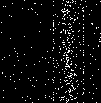


1 8583


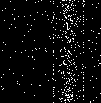


2 200


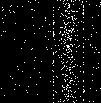


3 4442


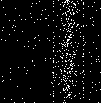


4 3836


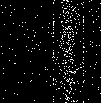


5 7876


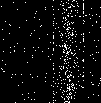


6 1917


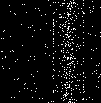


7 8381


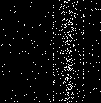


8 2321


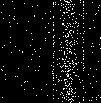


9 9492


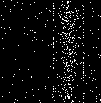


10 8179


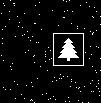


11 1311


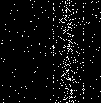


12 5048


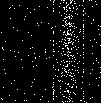


13 5149


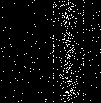


14 99


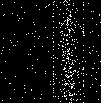


15 9290


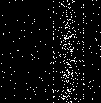


16 9795


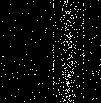


17 10098


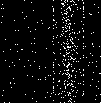


18 4543


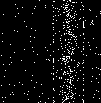


19 4745


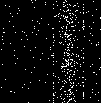


20 6260


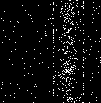


21 4644


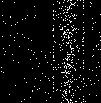


22 402


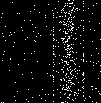


23 6563


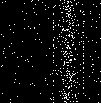


24 3432


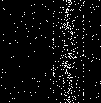


25 1715


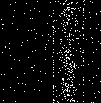


26 7977


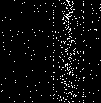


27 1210


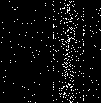


28 8684


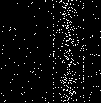


29 8785


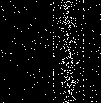


30 2523


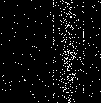


31 6462


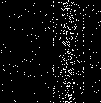


32 3634


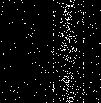


33 5553


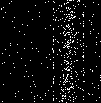


34 4038


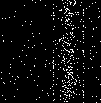


35 9896


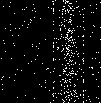


36 2018


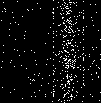


37 6664


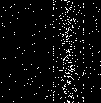


38 301


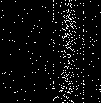


39 3331


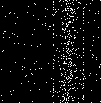


40 705


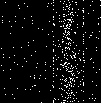


41 7068


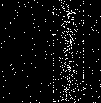


42 2220


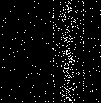


43 9391


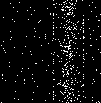


44 6866


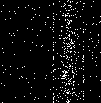


45 6058


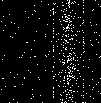


46 7775


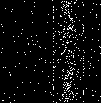


47 6765


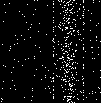


48 9088


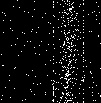


49 1109


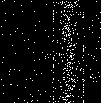

In [19]:
for i, arrangement in enumerate(robot_arrangements[0:50]):
    t = arrangement[0]
    area = arrangement[1]
    print(i, t)
    print_robot_positions(area)
    print()

Huzzah! After all our hard work, we see that the robot arrangement with the **11th smallest safety factor** has a Christmas tree!

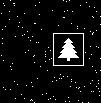

In [21]:
print_robot_positions(robot_arrangements[10][1])

This was definitely my favorite day of Advent of Code this year. I enjoyed how **open-ended and not well-defined** it was, paving the way for many different and unique solutions. I saw on Reddit that many people just exported *all* $10403$ images and used the preview function on their file explorers to be able to quickly inspect all of the images for the Christmas tree. 

Many others also used the intuitive idea of entropy like I did but used a different way of measuring that entropy. I saw some people look at the **variances** in the $x$ and $y$ directions and looked for arrangements with low variance in both coordinates to measure low entropy. I think my favorite method to measure entropy was someone who exported all the images, compressed them all, and checked which one **compressed the most**. It's crazy how so many people had the same fuzzy idea to test for structure/entropy but they all leveraged their unique technical backgrounds and strengths to use very different tools to tackle the same idea.

# [Day 15: Warehouse Woes](https://adventofcode.com/2024/day/15)

In [1]:
file = open('input15.txt', 'r')
input_text = file.read()
file.close()

In [3]:
def get_warehouse_and_moves(input_text):
    warehouse_input, moves_input = lines = input_text.strip().split('\n\n')
    warehouse_input = warehouse_input.splitlines()
    warehouse = []
    for i, row in enumerate(warehouse_input):
        warehouse_row = []
        for j, char in enumerate(row):
            warehouse_row.append(char)
            if char == "@":
                start = np.array([i,j])
        warehouse.append(warehouse_row)

    moves = ""
    for move in moves_input.splitlines():
        moves += move
        
    return warehouse, start, moves

In [4]:
warehouse, start, moves = get_warehouse_and_moves(input_text)

Given our robot's position and an attempted move direction $d$, we will **trace out a ray** to look at all the positions in direction $d$ from our robot's position until we hit a barrier `#`. After tracing this ray, we just need to check if there is a free space `.` for the robot and any succeeding boxes `O` to move into. If there's no free space before the barrier, we don't do anything. Otherwise, we shift everything before the position of the **first free space** one position in direction $d$.

In [5]:
move_key = {'<': np.array([0,-1]), 'v': np.array([1,0]), '>': np.array([0,1]), '^': np.array([-1,0])}
# Trace the ray in the specified direction
def trace_ray(start, move, matrix):
    ray = [matrix[start[0]][start[1]]]
    current = np.copy(start)
    direction = move_key[move]
    while matrix[current[0]][current[1]] != "#":
        current += direction
        ray.append(matrix[current[0]][current[1]])
    return ray

# Updates the state of the warehouse to perform a successul move
def update_state(start, move, new_state, matrix):
    current = np.copy(start)
    direction = move_key[move]
    for char in new_state:
        matrix[current[0]][current[1]] = char
        current += direction
        
def make_move(position, move, matrix):
    ray = trace_ray(position, move, matrix)
    if '.' in ray:
        free_space = ray.index('.')
        # Move everything preceding the first free space one position and add a free space at the robots initial position.
        new_state = ['.'] + ray[:free_space]
        update_state(position, move, new_state, matrix)
        return True
    return False

Now we run all the moves and sum up the final GPS coordinates.

In [6]:
current = np.copy(start)
for move in moves:
    current = current + move_key[move] if make_move(current, move, warehouse) else current

In [7]:
total = 0
for i, row in enumerate(warehouse):
    for j, char in enumerate(row):
        if char == "O":
            total += 100 * i + j
total

1413675

## Part 2

Let's create a new function to parse our input into this new, double-wide warehouse.

In [8]:
def get_warehouse_and_moves2(input_text):
    warehouse_input, moves_input = lines = input_text.strip().split('\n\n')
    warehouse_input = warehouse_input.splitlines()
    warehouse = []
    for i, row in enumerate(warehouse_input):
        warehouse_row = []
        for j, char in enumerate(row):
            if char == "@":
                warehouse_row += [char, '.']
                start = np.array([i,2*j])
            elif char == "O":
                warehouse_row += ['[',']']
            else:
                warehouse_row += [char, char]
        warehouse.append(warehouse_row)

    moves = ""
    for move in moves_input.splitlines():
        moves += move
        
    return warehouse, start, moves

In [9]:
warehouse, start, moves = get_warehouse_and_moves2(input_text)

In Part 1, when attempting to push a box, we only had to worry about what was directly behind the box to figure out if we could move or not. While this remains true for left/right moves in Part 2, we now have to worry about a **cascading effect** when we attempt to move a box in a vertical direction. For instance, pushing one box could push two boxes in the next layer, and those two boxes could potentially push more boxes, and so forth. In the given example, the expected behavior looks like:
```
##############
##......##..##
##..........##
##...[][]...##
##....[]....## 
##.....@....##
##############

Move ^:
##############
##......##..##
##...[][]...##
##....[]....##
##.....@....##
##..........##
##############

Move ^:
##############
##......##..##
##...[][]...##
##....[]....##
##.....@....##
##..........##
##############
```
where the first up move pushes all the boxes up one, but the second does nothing because the right side of the top right box has a barrier above it.

To account for this branching behavior, we would want to use a **tree-like structure** to indicate what each part of each relevant box is touching. So in the above example, we would want something like this at the beginning:

<center><img src="tree.png" width="400"/></center>

Since the robot contacts the right part of the bottom box from below, we want to indicate that the robot will push **both the left and right components** of the lower box. We do this by representing both components of the bottom box as children of the robot in our tree. Continuing with this example, the left part of the lower box contacts the right part of the top-left box, so we assign it both the components of the top-left box as children. We do the same with the right part of the lower box and the top-right box. Since the top boxes don't contact any other boxes vertically, we give each of the corresponding nodes a **single child** to indicate whether there is a free space or wall directly above it.

Because there is **free space above all the top boxes**, we are able to move all of these boxes up one position. Now, consider what happens when the robot tries to move up again:

<center><img src="tree2.png" width="400"/></center>

Our tree mostly stays the same except the right part of the top-right box now has a **wall** directly above it. This barrier prevents the robot from moving up any further.

So the way to determine whether our robot can execute a vertical move is to create this tree-like structure to give us what contact there is between the robot and adjacent boxes (if any). After we've done so, we check if all the leaves of this tree (nodes with no children) are free or not. If they are all free, the robot can succesfully complete the move. Otherwise, if there is at least one wall, the robot cannot move.

The reason we say "tree-like structure" instead of using a proper tree is that we could have a node with multiple parents. If we modify the above warehouse slightly, we get:
```
##############
##......##..##
##....[]....##
##...[][]...##
##....[]....## 
##.....@....##
##############
```

which would require the following directed graph to represent an attempted `^` move:

<center><img src="digraph.png" width="400"/></center>

Both the right part of the left-middle box and the left part of the right-middle box are contacting the top box, so both of the corresponding nodes will be parents of the nodes in the top box. Note that we also don't care about the depth of the leaves we are looking at. In this case, there are leaves at two different depths, but since they are all free spaces, the robot is able to push all of these boxes up.

Let's implement all of this.

In [15]:
class Node:
    def __init__(self, value):
        self.value = value
        self.children = set()
        self.parents = set()

    def add_child(self, child):
        self.children.add(child)

    def add_parent(self, parent):
        self.parents.add(parent)

    def print_node(self):
        print(f"value: {self.value}")
        print(f"children: {self.children}")
        print(f"parents: {self.parents}")

    def __repr__(self):
        return f"Node: {self.value}"

class Graph:
    def __init__(self, root_value):
        self.graph = {}
        self.root = self.add_node(root_value)
        
    # Don't want two nodes with the same value    
    def add_node(self, value):
        if tuple(value) not in self.graph.keys():
            node = Node(value)
            self.graph[tuple(value)] = node
            return node
        else:
            return self.get_node(value)

    def add_edge(self, node1, node2):
        node1.add_child(node2)
        node2.add_parent(node1)

    def get_node(self, value):
        return self.graph[tuple(value)]

    def print_graph(self):
        for node in self.graph:
            node.print_node()

    def get_leaves(self):
        leaves = set()
        for node in self.graph.values():
            if len(node.children) == 0:
                leaves.add(node)
        return leaves
             
    def __repr__(self):
        return f"Graph: {[node for node in self.graph.values()]}"
    

In [11]:
import copy

# Recursive function to add children to a node
def add_children(move, matrix, node, graph):
    position = node.value
    # Determine whether robot is moving up or down
    next_position = position + move_key[move]
    next_value = matrix[next_position[0]][next_position[1]]
    # If there is no box in the next position, just add one child
    if next_value in ".#":
        leaf = graph.add_node(next_position)
        graph.add_edge(node, leaf)
    else:
        # If the next value is '[' or ']', add the two pieces of the corresponding box as children to the current node
        if next_value == "[":
            left = graph.add_node(next_position)
            right = graph.add_node(next_position + np.array([0,1]))
        else: 
            right = graph.add_node(next_position)
            left = graph.add_node(next_position - np.array([0,1]))
        graph.add_edge(node, left)
        graph.add_edge(node, right)
        #Recursively add children for these new nodes
        add_children(move, matrix, left, graph)
        add_children(move, matrix, right, graph)

# Initialize the root node (corresponding to the robot) and add all children
def trace_tree(start, move, matrix):
    current = np.copy(start)
    graph = Graph(current)
    if move not in '^v':
        print('ERROR')
        return
    add_children(move, matrix, graph.root, graph)
    return graph

Now that we've implemented our desired graph structure, all we need to do is **update** our warehouse appropriately. As we said before, if there is a wall in any of the leaves, we **do nothing**. Otherwise, we are able to move, and we want to **shift every character** one step vertically in the given direction.

In [12]:
def update_warehouse(position, move, graph, matrix):
    leaves = graph.get_leaves()
    # If there is a wall in any of the leaves, don't do anything
    if '#' in [matrix[node.value[0]][node.value[1]] for node in leaves]:
        return False
    tmp = copy.deepcopy(matrix)
    direction = move_key[move]
    # Move each internal node one spot in the given direction
    for index, node in graph.graph.items():
        if node not in leaves:
            # Copy the value of the current cell into the cell one step in the given direction
            next_index = np.array(index) + direction
            previous_index = np.array(index) - direction
            matrix[next_index[0]][next_index[1]] = tmp[index[0]][index[1]]

            # Replace the current cell with either a free space or the object that is pushing it
            if index[1] not in [parent.value[1] for parent in node.parents]:
                matrix[index[0]][index[1]] = '.'
            else:   
                matrix[index[0]][index[1]] = tmp[previous_index[0]][previous_index[1]]
    return True        

def make_move2(position, move, matrix):
    if matrix[position[0]][position[1]] != "@":
        print("Can only move '@'")
        return
        
    if move in '<>':
        return make_move(position, move, matrix)
    else:
        graph = trace_tree(position, move, matrix)
        return update_warehouse(position, move, graph, matrix)

As we did in Part 1, we run all the moves and sum up the final GPS coordinates.

In [13]:
current = np.copy(start)
for move in moves:
    current = current + move_key[move] if make_move2(current, move, warehouse) else current

In [14]:
total = 0
for i, row in enumerate(warehouse):
    for j, char in enumerate(row):
        if char == "[":
            total += 100 * i + j
total

1399772

# [Day 16: Reindeer Maze](https://adventofcode.com/2024/day/16)

## Part 1

In [5]:
file = open('input16.txt', 'r')
input_text = file.read()
file.close()

In [6]:
def read_maze(input_text):
    lines = input_text.strip().splitlines()
    maze = []
    for i, line in enumerate(lines):
        row = []
        for j, char in enumerate(line):
            if char == "S":
                start = np.array([i,j])
            if char == "E":
                end = np.array([i,j])
            row.append(char)
        maze.append(row)
    return maze, start, end

In [7]:
maze, start, end = read_maze(input_text)

This is a **shortest path problem**. As we've already seen in Days 10 and 12, we can view our maze as a graph with each position in the maze as a vertex and each pair of adjacent positions as edges. To account for the fact that rotations increase our score by 1000 points, we will modify our graph construction slightly. Let $G = (V,E)$ with vertices given by $V = \{(i, j, \text{direction}) \ | \ (i,j) \in \text{maze} , \ \text{direction} \in \set{N, E, S, W}\}$. 

For each maze position $(i,j)$, we will add edges of weight `1000` between directions that are a **90-degree rotation** apart, e.g. $(i, j, N)$ and $(i, j, E)$. Additionally, for any pair of **vertically adjacent** positions $(i, j), (i+1,j)$ in our maze, we will add edges $\set{(i, j, N), (i+1, j, N)}$ and $\set{(i, j, S), (i+1, j, S)}$ of weight `1`. Similarly, for **horizontally adjacent** positions $(i, j), (i, j+1)$, we will add edges $\set{(i, j, E), (i, j+1, E)}$ and $\set{(i, j, W), (i, j+1, W)}$.

Let's denote $(s_1, s_2)$ as our starting position and $(e_1, e_2)$ as our ending position. Since the Reindeer **start facing `East`**, we will run **Djikstra's algorithm** on $G$ with $(s_1, s_2, E)$ as our source. Then to find the lowest score a Reindeer could possibly get, we check the minimum distance amongst $(e_1, e_2, \text{direction})$ for any $\text{direction} \in \set{N, E, S, W}$.

First, let's implement our graph as an **adjacency list**.

In [8]:
direction_map = {"N": np.array([-1,0]), "E": np.array([0,1]), "S": np.array([1,0]), "W": np.array([0,-1])}

from collections import defaultdict
adjacency_list = defaultdict(dict)
for i, row in enumerate(maze):
    for j, char in enumerate(row):
        if char != "#":
            current = np.array([i,j])
            for direction, direction_vector in direction_map.items():
                neighbor = current + direction_vector
                if maze[neighbor[0]][neighbor[1]] != "#":
                    adjacency_list[(i, j, direction)][(*neighbor, direction)] = 1
                    adjacency_list[(*neighbor, direction)][(i, j, direction)] = 1
                for other_direction, other_direction_vector in direction_map.items():
                    if np.dot(direction_vector, other_direction_vector) == 0:
                        adjacency_list[(i, j, direction)][(i, j, other_direction)] = 1000
                        adjacency_list[(i, j, other_direction)][(i, j, direction)] = 1000

Now we'll implement Djikstra's algorithm using a **min-heap**.

In [9]:
from heapq import heappush, heappop, heapify

distances = {}
heap = []
heappush(heap, (0, (*start, 'E')))

while len(heap) > 0:
    current_distance, vertex = heappop(heap)
    if vertex in distances:
            continue
    distances[vertex] = current_distance
    for neighbor, neighbor_distance in adjacency_list[vertex].items():
        if neighbor not in distances:
            heappush(heap, (current_distance + neighbor_distance, neighbor))
    

Finally, we get the minimum score among all our vertices corresponding to our end position.

In [10]:
end_positions = {tuple(end) + (direction,) for direction in "NESW"}
minimum = float('inf')
for end_position in end_positions:
    distance = distances[end_position]
    print(end_position, distance)
    minimum = distance if distance < minimum else minimum
minimum

(1, 139, 'E') 94436
(1, 139, 'W') 94436
(1, 139, 'S') 93436
(1, 139, 'N') 93436


93436

## Part 2

We will use dynamic programming to find all points that lie on a shortest path. In general, if we have a weighted graph $G$, source and target nodes $s$ and $t$, and the distances of every node from $s$, we can compute the shortest paths from $s$ to $t$ recursively. We start with our target node $t$ since every shortest path from $s$ to $t$ must end at $t$. Then if $u$ is a neighbor of $t$, it lies on a shortest path from $s$ to $t$ if and only if the **distance between $s$ and $t$ is equal to the distance between $s$ and $u$ plus the weight of $\set{u,t}$**.

In our case, our source will be $(s_1, s_2, E)$ and we will consider any target $(e_1, e_2, \text{direction})$ that achieves the minimum score from Part 1.

In [11]:
memoization = {}
def get_best_seats(end, distances):
    best_seats = {end}
    if end == tuple(start) + ("E",):
        memoization[end] = best_seats
        return best_seats
    min_distance = distances[end]
    for neighbor, distance in adjacency_list[end].items():
        if distances[neighbor] == min_distance - distance:
            if neighbor not in memoization.keys():
                memoization[neighbor] = get_best_seats(neighbor, distances)
            best_seats |= memoization[neighbor]       
    return best_seats

In [12]:
best_seats = set()
for end_position in end_positions:
    if distances[end_position] == minimum:
        best_seats |= get_best_seats(end_position, distances)

Now we just count the number of distinct coordinates in our maze that show up in our shortest paths.

In [13]:
best_seats = {seat[:2] for seat in best_seats}
len(best_seats)

486

# [Day 17: Chronospatial Computer](https://adventofcode.com/2024/day/17)

## Part 1

In [2]:
file = open('input17.txt', 'r')
input_text = file.read()
file.close()

In [3]:
def load_program(input_text):
    registers, program = input_text.strip().split('\n\n')
    registers = registers.split('\n')
    registers = [int(register.split(' ')[-1]) for register in registers]
    registers = {"A": registers[0], "B": registers[1], "C": registers[2]}
    program = [int(bit) for bit in program[9:].split(',')]
    return registers, program

In [4]:
registers, program = load_program(input_text)

This part should be easy. All we have to do is create a bunch of conditional statements following all the rules for handling different opcodes and operands. We also want to save the output of the program as a list.

In [5]:
def combo_operand(operand):
    if operand >= 0 and operand <= 3:
        return operand
    elif operand  == 4:
        return registers['A']
    elif operand == 5:
        return registers['B']
    elif operand == 6:
        return registers['C']
    else:
        return "ERROR: invalid combo operand"

program_output = []
def execute_operation(pointer, program):
    opcode = program[pointer]
    operand = program[pointer + 1] 
    if opcode == 0:
        registers['A'] = int(registers['A']/(2**combo_operand(operand)))
    elif opcode == 1:
        registers['B'] = registers['B'] ^ operand
    elif opcode == 2:
        registers['B'] = combo_operand(operand) % 8
    elif opcode == 3:
        if registers['A'] != 0:
            return operand
    elif opcode == 4:
        registers['B'] = registers['B'] ^ registers['C']
    elif opcode == 5:
        program_output.append(combo_operand(operand) % 8)
    elif opcode == 6:
        registers['B'] = int(registers['A']/(2**combo_operand(operand)))
    elif opcode == 7:
        registers['C'] = int(registers['A']/(2**combo_operand(operand)))
    return pointer + 2 

def run_program(program):
    pointer = 0
    while pointer < len(program):
        pointer = execute_operation(pointer, program)

In [6]:
run_program(program)

In [7]:
",".join([str(output) for output in program_output])

'1,6,3,6,5,6,5,1,7'

## Part 2

Let's convert this itty-bitty machine code to Python, so we can make more sense of it. Every instruction except for `jnz` and `out` just performs some bitwise operation and writes it to one of our registers.

Our program is given by `2,4,1,1,7,5,4,0,0,3,1,6,5,5,3,0`. All of these are bitwise operations except for the last two intsructions. The second to last instruction tells us to output the value of the `combo` operand `5`, and the last instruction tells us to jump to the beginning of the program if register `A` isn't `0`. Thus, we can view this program as **the following `while` loop**:

In [9]:
def compute(A, B, C):
    output = []
    while A != 0:
        B = A % 8 # 2, 4
        B = B ^ 1 # 1, 1
        C = A >> B # 7, 5
        B = B ^ C # 4, 0
        A = A >> 3 # 0, 3
        B = B ^ 6 # 1, 6
        output.append(str(B % 8)) # 5, 5
    return (",").join(output)

In [10]:
initial_registers, _ = load_program(input_text)
compute(initial_registers['A'],0,0)

'1,6,3,6,5,6,5,1,7'

Nice, it works! Now we observe that registers `B` and `C` get assigned based on the value of register `A` each time in the loop, so it doesn't matter what those initial register values are. We also know that for every iteration, we **output once and then right shift `A` by three bits**. This means that to print exactly `n = len(program)` times, we need an integer with **at most $3 \cdot n$ bits** and **at least $3 \cdot n-2$ bits** in its binary representation. Moreover, **the last $k$ outputs are only dependent on the first $3 \cdot k$ bits of $A$**. Let's see how we can leverage this to figure out what the initial value of register `A` must be to output our program.

Let $x = x_1x_2x_3\ldots x_{3n-1}x_{3n}$ denote the binary respresentation of the lowest possible initial value for register `A` that causes the program to output a copy of itself. We know we want the last output to be a `0` and that this only depends on the first 3 bits $x$. In particular, if we initialize register `A` with the integer corresponding to $x_1x_2x_3$ and run our program, the program should output a **single value equal to `0`**. This means we can reverse engineer $x_1x_2x_3$ by running our program with every 3-bit integer as our initial value for register `A`, and checking which ones output `0`. Since $0$ through $7$ are the only 3-bit integers, we just have to check these values.

In [11]:
for i in range(8):
    print(f"A = {i}, output = {compute(i, 0, 0)}")

A = 0, output = 
A = 1, output = 7
A = 2, output = 5
A = 3, output = 4
A = 4, output = 3
A = 5, output = 2
A = 6, output = 1
A = 7, output = 0


Since $7$ is the only 3-bit integer that would cause our program to output `0`, we know $x_1x_2x_3 = 111$. Now we can **continue inductively** to figure out what the next triple of bits should be. We do this by concatenating all triples of bits to $111$ and checking which one outputs the last two values of our output, `3,0`.

In [12]:
for i in range(8):
    initial_value = (7 << 3) + i
    print(f"A = {i}, output = {compute(initial_value, 0, 0)}")

A = 0, output = 3,0
A = 1, output = 7,0
A = 2, output = 2,0
A = 3, output = 2,0
A = 4, output = 2,0
A = 5, output = 1,0
A = 6, output = 1,0
A = 7, output = 0,0


Here we see that $0$ is the only 3-bit integer that gives us our desired output, so the **first six bits of $x$ must be $111000$**. Now we repeat until we've done this $n$ times and get our answer. One point of concern, though, is that in the above computation, there were multiple 3-bit integers we could append that would give the same 2-value output. It did not happen to us this time, but it might be the case that there are **multiple 3-bit integers we could choose** from that would output the correct answer at a given inductive step. Let's see what happens if we repeat this process one more time.

In [13]:
for i in range(8):
    initial_value = (((7 << 3) + 0) << 3) + i
    print(f"A = {i}, output = {compute(initial_value, 0, 0)}")

A = 0, output = 7,3,0
A = 1, output = 7,3,0
A = 2, output = 5,3,0
A = 3, output = 4,3,0
A = 4, output = 5,3,0
A = 5, output = 6,3,0
A = 6, output = 2,3,0
A = 7, output = 7,3,0


Indeed, concatenating both $2$ and $4$ outputs the last 3 values of our program correctly. Thus, the first nine bits of $x$ could be $111000001$ or $111000010$. To address this, if at any step we have multiple 3-bit integers to choose from, we will keep track and apply our inductive process to *all* of the corresponding concatenated strings.

In [14]:
valid = []
def induct(initial3k):
    # Try concatenating all triples of bits to our current working string of 3k bits
    for i in range(8):
        # In the base case where we find our first three bits, we don't want to consider i=0 as this won't output anything
        if initial3k == 0 and i == 0:
            continue
            
        # Append the binary representation of i to the binary representation of our string of 3k bits
        concatenated = (initial3k << 3) + i
        output = compute(concatenated, 0, 0)

        # If the output matches the last bits of our program, we recurse
        if output == (",").join([str(entry) for entry in program[-(len(output.split(','))):]]):
            # Store all the values that give us our entire output
            if output == (",").join([str(entry) for entry in program]):
                valid.append(concatenated)
            induct(concatenated)

Since  we start with an empty string, we call `induct` on `0`, and this should recursively give us every valid initial value for `A`.

In [15]:
induct(0)
valid.sort()
valid

[247839653009594,
 247839653009595,
 247839653009599,
 247839653009914,
 247839653009915,
 247839653009918]

Finally, we verify that this outputs our program.

In [16]:
compute(min(valid), 0, 0)

'2,4,1,1,7,5,4,0,0,3,1,6,5,5,3,0'

**Great.**

# [Day 18: RAM Run](https://adventofcode.com/2024/day/18)

## Part 1

In [2]:
file = open('input18.txt', 'r')
input_text = file.read()
file.close()

In [3]:
def read_corrupted(input_text):
    lines = input_text.strip().splitlines()
    corrupted = []
    for line in lines:
        i, j = [int(coord) for coord in line.split(',')]
        corrupted.append((i,j))
    return corrupted

In [4]:
corrupted = read_corrupted(input_text)

First let's create a grid to represent our memory after the first kilobyte has fallen onto it. As we've done before, we will pad the boundaries of our grid to avoid out of bounds errors. 

In [5]:
blank_memory = []
blank_memory.append(['#' for i in range(73)])
for i in range(71):
    row = ['#']
    for j in range(71):
        row.append('.')
    row.append('#')
    blank_memory.append(row)
blank_memory.append(['#' for i in range(73)])

import copy
memory = copy.deepcopy(blank_memory)
for byte in corrupted[:1024]:
    x, y = byte
    memory[y+1][x+1] = '#'

This will clearly be a **shortest path problem** between `(0,0)` and `(70,70)`. Since we've already implemented Djikstra's in Day 16, we're allowed to cheat and use an external library to do this.

In [6]:
import networkx as nx

G = nx.Graph()
directions = [np.array(direction) for direction in [(0,1),(0,-1),(1,0),(-1,0)]]
def add_neighbors(position, memory, graph):
    for direction in directions:
        neighbor = position + direction
        if memory[neighbor[0]][neighbor[1]] == '.':
            graph.add_edge(tuple(position), tuple(neighbor))

In [7]:
for i, row in enumerate(memory):
    for j, char in enumerate(row):
        if char == ".":
            G.add_node((i,j))
            add_neighbors(np.array([i,j]), memory, G)

In [8]:
nx.shortest_path_length(G, (1,1), (71,71))

356

Thanks `networkx`! Recall that since our grid is padded, our `X` and `Y` coordinates are all 1-indexed, which is why we look at `(1,1)` and `(71,71)` in `G`.

## Part 2

Let's create a function that tests whether `(0,0)` and `(70,70)` are still connected after `k` bytes have fallen. 

In [11]:
def connected(t):
    memory = copy.deepcopy(blank_memory)
    for byte in corrupted[:t]:
        x, y = byte
        memory[y+1][x+1] = '#'

    G = nx.Graph()
    for i, row in enumerate(memory):
        for j, char in enumerate(row):
            if char == ".":
                G.add_node((i,j))
                add_neighbors(np.array([i,j]), memory, G)
    try:
        nx.shortest_path_length(G, (1,1), (71,71))
        return True
    except:
        return False

Now we can just use **binary search** to find the first time the exit is unreachable from the starting position.

In [14]:
window_size = len(corrupted) >> 1
t = window_size

while window_size > 0:
    if connected(t) and not connected(t+1):
        break
    window_size >>= 1
    t = t + window_size if connected(t) else t - window_size

And we can get the coordinates at this time.

In [15]:
corrupted[t]

(22, 33)

# [Day 19: Linen Layout](https://adventofcode.com/2024/day/19)

## Part 1

In [5]:
file = open('input19.txt', 'r')
input_text = file.read()
file.close()

In [6]:
def get_patterns_and_designs(input_text):
    patterns, designs = input_text.strip().split('\n\n')
    patterns = set(patterns.split(', '))
    designs = designs.splitlines()
    return patterns, designs

In [7]:
patterns, designs = get_patterns_and_designs(input_text)

This is another typical **dynamic programming** problem. We know that a design is possible if and only if it is the **concatenation of a towel pattern and another possible design**. Thus, given a design, we can split it into two strings `first` and `second` and check if `first` is a towel pattern and use recursion to see if `second` is a possible design. The length of `first` can vary from `1` to the maximum length of a towel pattern.

In [8]:
max_length = max(len(pattern) for pattern in patterns)
design_memoization = {}
def is_possible(design):
    # Base case
    if design in patterns:
        return True

    for i in range(1, min(max_length, len(design)) + 1):
        # Split our design
        first = design[:i]
        second = design[i:]
        # If the first part of the design isn't a towel pattern, this design cannot be valid
        if first not in patterns:
            continue
        # Compute if the second part of the design is possible if we haven't already
        if second not in design_memoization.keys():
            design_memoization[second] = is_possible(second)
        # If both parts are possible this design is possible
        if design_memoization[second]:
            return True
    # If there is no way to split this design into two smaller possible designs, this design is impossible
    return False

In [9]:
possible = list(filter(is_possible, designs))
len(possible)

302

## Part 2

This recursion is almost the exact same as Part 1 except now we just keep track of the number of possible designs.

In [10]:
possible_designs_memoization = {}
def get_possible_designs(design):
    possible_designs = 0
    if design in patterns:
        possible_designs += 1
    
    for i in range(1, min(max_length, len(design)) + 1):
        first = design[:i]
        second = design[i:]
        if first not in patterns:
            continue
        if second not in possible_designs_memoization.keys():
            possible_designs_memoization[second] = get_possible_designs(second)
        possible_designs += possible_designs_memoization[second]
        
    return possible_designs 

In [11]:
possible_designs = [get_possible_designs(design) for design in designs]

In [12]:
sum(possible_designs)

771745460576799

# [Day 20: Race Condition](https://adventofcode.com/2024/day/20)

## Part 1

In [2]:
file = open('input20.txt', 'r')
input_text = file.read()
file.close()

In [3]:
import networkx as nx
import copy

def read_racetrack(input_text):
    lines = input_text.strip().splitlines()
    racetrack = []
    for i, line in enumerate(lines):
        row = []
        for j, char in enumerate(line):
            if char == "S":
                start = (i,j)
            if char == "E":
                end = (i,j)
            row.append(char)
        racetrack.append(row)
    return racetrack, start, end

In [4]:
racetrack, start, end = read_racetrack(input_text)

Let's get the **unique path** through the racetrack.

In [5]:
directions = [np.array(direction) for direction in [(0,1),(0,-1),(1,0),(-1,0)]]
current = np.array(start)
path = [start]
while tuple(current) != end:
    for direction in directions:
        neighbor = current + direction
        if racetrack[neighbor[0]][neighbor[1]] != '#' and tuple(neighbor) not in path:
            path.append(tuple(neighbor))
            current = neighbor
            break

To check all possible cheats starting at a certain position $p$, we look at all points $q$ in our racetrack that are **two steps away**. For each $q$, we check that this point is in the unique path. Then if $\text{index of }q - \text{index of }p - 2 > 0$, we know we will have a successful cheat. This is because we will have **cut out $\text{index of }q - \text{index of }p$ steps** and **replaced it with the $2$ steps** taken to use the cheat.

In [6]:
# Store the indices of each node in our path to save lookup time
path_index = {node: i for i, node in enumerate(path)}
def check_shortcuts(position, racetrack, path, shortcuts):
    for first_step in directions:
        neighbor = position + first_step
        for second_step in directions:
            next_neighbor = neighbor + second_step
            if tuple(next_neighbor) in path_index:
                distance_saved = path_index[tuple(next_neighbor)] - path_index[position] - 2
                if distance_saved >= 100:
                    shortcuts[(position, tuple(next_neighbor))] = distance_saved

Now we just apply this function to every point in our path.

In [7]:
shortcuts = {}
for node in path:
    check_shortcuts(node, racetrack, path, shortcuts)

In [8]:
len(shortcuts)

1417

## Part 2

We will do the same thing as above, but now to check for shortcuts starting at a position $p$, we look at **all neighbors $q$ that are within `20` steps** of $p$. Then as before, if $q$ is in our path, we **cut out $\text{index of }q - \text{index of }p$ steps** and replace it with the **number of steps it takes to get from $p$ to $q$**. f this difference is greater than `100`, we keep track of it. Note that the neighbors of $p$ that are within `20` steps can be given **formulaically** by the set $\set{p + (\pm i, \pm(j-i)) \ | \ 1 \leq j \leq 20, \ 0 \leq i \leq j}$ where $j$ indicates the number of steps taken from $p$.

In [9]:
def check_shortcuts20(position, racetrack, path, shortcuts):
    x, y = position
    for j in range(1,21):
        for i in range(0,j+1):
            neighbors = [(x + i, y + j - i), (x + i, y - (j - i)), (x - i, y + j - i), (x - i, y - (j - i))]
            for neighbor in neighbors:
                if neighbor in path_index:
                    distance_saved = path_index[neighbor] - path_index[position] - j
                    if distance_saved >= 100:
                        shortcuts[(position, neighbor)] = distance_saved

In [10]:
shortcuts20 = {}
for i, node in enumerate(path):
    check_shortcuts20(node, racetrack, path, shortcuts20)

In [11]:
len(shortcuts20)

1014683

# Day 21

# [Day 22: Monkey Market](https://adventofcode.com/2024/day/22)

## Part 1

In [2]:
file = open('input22.txt', 'r')
input_text = file.read()
file.close()

In [3]:
def get_secret_numbers(input_text):
    return [int(number) for number in input_text.strip().splitlines()]

In [4]:
numbers = get_secret_numbers(input_text)

There shouldn't be anything fancy here. We just need to implement one iteration of the appropriate mixing and pruning and then run this `2000` times.

In [5]:
def generate_next_number(secret_number):
    secret_number = (secret_number ^ (secret_number << 6)) % 16777216
    secret_number = (secret_number ^ (secret_number >> 5)) % 16777216
    secret_number = (secret_number ^ (secret_number << 11)) % 16777216
    return secret_number

def get_price(secret_number, iterations):
    current = secret_number
    for i in range(iterations):
        current = generate_next_number(current)
    return current

In [6]:
total = 0
for secret_number in numbers:
    total += get_price(secret_number, 2000)
total

14691757043

## Part 2

Now we modify `get_price` slightly to just look at the last digit of each secret number and to return the entire list of prices.

In [7]:
def get_price_list(secret_number, iterations):
    current = secret_number
    price_list = [current % 10]
    for i in range(iterations):
        current = generate_next_number(current)
        price_list.append(current % 10)
    return price_list

Now for each monkey, we simply **iterate through every sequence of 4 consecutive price changes** out of the list of `2000`. For a given sequence of price changes $(\Delta_1, \Delta_2, \Delta_3, \Delta_4)$, we keep track of the price after $\Delta_4$ if this is the first time we see this sequence of price changes. Otherwise, we do nothing. This gives all possible sequences of 4 consecutive price changes that will **yield a sale from this monkey vendor**. Doing this over all monkeys and summing up all the values for each sequence of price changes will give us the one that will get us the most bananas overall.

In [8]:
from collections import defaultdict
price_change_sequences = defaultdict(int)
for secret_number in numbers:
    price_list = get_price_list(secret_number, 2000)
    # Keep track of the sequences of price changes we've seen before
    seen = set()
    for i in range(len(price_list) - 4):
        # Get the sequence of 4 consecutive price changes starting at the ith iteration
        change_sequence = tuple(price_list[i+j+1] - price for j, price in enumerate(price_list[i:i+4]))
        if change_sequence not in seen:
            # Add the number of bananas we'd get from this monkey and price change sequence
            price_change_sequences[change_sequence] += price_list[i+4]
            seen.add(change_sequence)

In [9]:
print(max(price_change_sequences, key=price_change_sequences.get))
print(max(price_change_sequences.values()))

(0, -1, 0, 1)
1831


# [Day 23: LAN Party](https://adventofcode.com/2024/day/23)

In [2]:
file = open('input23.txt', 'r')
input_text = file.read()
file.close()

In [3]:
import networkx as nx
def read_graph(input_text):
    edges = input_text.strip().splitlines()
    G = nx.Graph()
    for edge in edges:
        vertices = edge.split('-')
        G.add_edge(vertices[0], vertices[1])
    return G

In [4]:
G = read_graph(input_text)

This one is pretty easy if you know some **graph theory**. We can model our **computers as vertices** of a graph and the **connections as edges**. Recall that a subset of $n$ vertices of a graph is called an **$n$-clique** if every pair of these $n$ vertices is an edge in the graph. Thus, Part 1 is asking us to find the number of $3$-cliques that contain a computer with a name that starts with a `t`.

We will use `networkx` again. In fact, `networkx` already has a method to find cliques, but we will only use the library to represent our graph and check edge relations.

In [5]:
import itertools
t_nodes = [node for node in G.nodes if node[0] == "t"]
three_cliques = set()
for node in t_nodes:
    neighbors = list(G.neighbors(node))
    pairs = itertools.combinations(neighbors, 2)
    for pair in pairs:
        if G.has_edge(*pair):
            three_cliques.add(frozenset([node, *pair]))

In [6]:
len(three_cliques)

1419

## Part 2

Now we want to find the **maximal clique** in our computer network. We can do this recursively. The key observation is that for an $n$-clique $C$, *any* subset of $n-1$ vertices $C'$ must form an $(n-1)$-clique. This means any $n$-clique $C$ is of the form $\set{v} \cup C'$ where $C'$ is an $(n-1)$-clique and $v$ is a vertex not in $C'$ that shares an edge with every vertex in $C'$. Computationally, if we know an $(n-1)$-clique $C'$, we can check if there are any common neighbors between all elements of $C'$ to see if it is part of an $n$-clique. Doing this over all $(n-1)$-cliques gives rise to all possible $n$-cliques.

In [7]:
cliques_memoization = {}

def get_n_cliques(G, n):
    if n in cliques_memoization.keys():
        return cliques_memoization[n]

    # The set of 1-cliques is just the set of vertices
    if n == 1:
        n_cliques = set([frozenset([node]) for node in G.nodes])
        cliques_memoization[1] = n_cliques
        return n_cliques

    # Look at all n-1 cliques
    n_1_cliques = get_n_cliques(G, n-1)
    n_cliques = set()
    for clique in n_1_cliques:
        # Check for common neighbors amongst all n-1 vertices
        common_neighbors = G.nodes
        for node in clique:
            neighbors = set(G.neighbors(node))
            common_neighbors = common_neighbors & neighbors
        # Any common neighbor gives us an n clique
        for common_neighbor in common_neighbors:
            new_clique = set(clique)
            new_clique.add(common_neighbor)
            n_cliques.add(frozenset(new_clique))
    cliques_memoization[n] = n_cliques
    return n_cliques

In [8]:
n = 1
current = get_n_cliques(G,n)
while len(current) > 0:
    n+= 1
    current = get_n_cliques(G,n)

In [9]:
n

14

It seems that `14` is the first value of `n` for which there are no $n$-cliques. This means the maximal clique size is `13`.

In [10]:
max_clique = next(iter(get_n_cliques(G,13)))
",".join(sorted(list(max_clique)))

'af,aq,ck,ee,fb,it,kg,of,ol,rt,sc,vk,zh'